In [1]:
from testproblems import random_problem_with_artifacts
from datastructures.api import OPT, VAR, COMP, SOLVER, OBJ
from datastructures.graphutils import edges_E, all_components, all_variables, sources, edges_to_Ein_Eout, flat_graph_formulation, root_solver, namefromid
from datastructures.operators import sort_scc, reorder_merge_solve
from datastructures.workflow import get_f, order_from_tree, default_solver_options, mdao_workflow, implicit_comp_name
from datastructures.workflow_mdao import mdao_workflow_with_args
from datastructures.assembly import build_archi
from datastructures.assembly import root_sources
from datastructures.execution import Component
from datastructures.runpipeline import nestedform_to_mdao
from datastructures.tearing import min_max_scc2, dir_graph
from datastructures.polycasebuilder import generate_random_polynomials, eqv_to_edges_tree
import networkx as nx
import numpy as np
from datastructures.rendering import render_incidence
import time
import openmdao.api as om

In [2]:
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True

In [3]:
def add_obj(inputids, var_mapping, edges, tree, components):
    inputvars = [var_mapping[elt][0] for elt in inputids]
    fobj = sum([(elt-1)**2 for elt in inputvars])
    newidx = 'obj'#len(edges[1])
    arg_mapping={key:v2 for key,(_,v2) in var_mapping.items()}
    c = Component.fromsympy(fobj, component=newidx, arg_mapping=arg_mapping)
    edges[0][newidx] = c.inputs
    edges[1][newidx] = c.outputs
    tree[0][newidx] = 1
    return components+[c], newidx

In [4]:
def generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf=True):
    components, newidx = add_obj(inputids, var_mapping, edges, tree, components) # mutates edges and tree aswell
    solvers_options = {1: {'type': OPT, 'disp':False}, 2:{'maxiter':200}}
    comp_options = {newidx:OBJ}
    dv = root_sources(edges, tree)
    for elt in dv:
        tree[2][elt] = 1
    var_options = {}
    nodetyperepr = {VAR: 'x_{}', COMP: 'f_{}', SOLVER: 's_{}'}
    prob, mdao_in, groups, formulation,merge_order = nestedform_to_mdao(edges, tree, components, solvers_options, comp_options, var_options, nodetyperepr, mdf)
    return prob, groups, formulation, merge_order

In [5]:
def measure_optimization(prob, groups, Stree):
    try:
        prob.set_solver_print(-1)
        tic = time.perf_counter()
        prob.run_driver()
        toc = time.perf_counter()
        total_iters = 0
        for key,var in Stree.items():
            parent = groups['s_{}'.format(var)]
            total_iters += getattr(parent, 's_{}'.format(key)).iter_count_apply
        objiter = groups['s_1'].f_obj.iter_count
        return prob.driver.result.fun, total_iters, objiter, toc-tic
    except:
        return 999, None, None, None

In [6]:
inputids_store = {}

In [7]:
def min_max_scc_calculations(eq_incidence=None, edges_varonleft=None, varidxs=None, eqnidxs=None, outset=None, probtype=None, seed_poly=None, mdf=None, **kwargs):
    if probtype == 2:
        xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=100)
        if xsol:
            outset = dict((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)
        else:
            return 999, 999, None, None, None
    D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, outset.items()))
    sccsize = max(len(elt) for elt in nx.strongly_connected_components(D))//2
    rng = np.random.default_rng(seed_poly)
    _, var_mapping, edges, tree, components = generate_random_polynomials(eq_incidence, outset, len(eqnidxs), rng)
    identifier = (kwargs['m'], kwargs['n'], kwargs['sparsity'], kwargs['seed'])
    if probtype == 2:
        inputids = sources(*edges_to_Ein_Eout(edges))
        inputids_store[identifier] = inputids
    else:
        inputids = inputids_store[identifier]
    prob, groups, formulation,_ = generate_mdao_prob(inputids, var_mapping, edges, tree, components, mdf)
    optim_results = measure_optimization(prob, groups, formulation[1][1])
    return (sccsize,)+optim_results

In [8]:
def generate_artifacts(m,n,sparsity,seed,probtype,seed_poly,mdf):
    kwargs = random_problem_with_artifacts(m,n,seed,sparsity)
    kwargs.update({
        "seed_poly": seed_poly,
        "probtype": probtype,
        "mdf": mdf
    })
    return kwargs

## Chapter example

In [162]:
kwargs = generate_artifacts(10,15,1.5,42,1,0,False) # 42 fails, need to debug

In [163]:
#inputids_store

In [164]:
#min_max_scc_calculations(**kwargs)

In [165]:
edges_varonleft, varidxs, eqnidxs = (kwargs[key] for key in ['edges_varonleft','varidxs','eqnidxs'])

In [279]:
xsol, m = min_max_scc2(edges_varonleft, varidxs, eqnidxs, timeout=100)
outset = dict((right, left) for left, right in edges_varonleft if xsol[left, right] > 0.5)

In [280]:
#outset = kwargs['outset']

In [341]:
D = nx.DiGraph(dir_graph(edges_varonleft, eqnidxs, outset.items()))
minssc = max(len(elt) for elt in nx.strongly_connected_components(D))//2

In [342]:
minssc

6

In [343]:
outset=kwargs["outset"]

In [355]:
mdf = True

In [356]:
eq_incidence = kwargs["eq_incidence"]

In [357]:
rng = np.random.default_rng(kwargs["seed_poly"])
polys, var_mapping, edges, tree, components = generate_random_polynomials(eq_incidence, outset, len(kwargs["eqnidxs"]), rng)
#inputids = sources(*edges_to_Ein_Eout(edges))
identifier = (kwargs['m'], kwargs['n'], kwargs['sparsity'], kwargs['seed'])
inputids_store[identifier] = inputids
inputids = inputids_store[identifier]

In [358]:
inputids_store

{(10, 15, 1.0, 2): {0, 2, 10, 11, 13},
 (10, 15, 1.0, 42): {0, 1, 3, 6, 12},
 (10, 15, 1.5, 42): {7, 9, 12, 13, 14}}

In [359]:
edges_sand = ({comp:tuple(var-10 for var in compvars) for comp, compvars in eq_incidence.items()}, {comp: (None,) for comp in eq_incidence.keys()},{})
tree_sand = (tree[0],{},{var:1 for var in range(len(varidxs))})
#edges = edges_sand
#tree = tree_sand

In [360]:
components, newidx = add_obj(inputids, var_mapping, edges, tree, components) # mutates edges and tree aswell
solvers_options = {1: {'type': OPT, 'disp':True}, 2:{'maxiter':30}}
comp_options = {newidx:OBJ}
dv = root_sources(edges, tree)
for elt in dv:
    tree[2][elt] = 1
var_options = {}
nodetyperepr = {VAR: 'x_{}', COMP: 'f_{}', SOLVER: 's_{}'}

In [361]:
G = flat_graph_formulation(*edges)
merge_order = sort_scc(G)
merge_parent = root_solver(tree) # all merged components will have this solver as the parent
ordered_edges, ordered_tree = reorder_merge_solve(edges, tree, merge_order, merge_parent, mdf)

In [362]:
namingfunc = namefromid(nodetyperepr)
sequence = order_from_tree(ordered_tree[0], ordered_tree[1], ordered_edges[1])
solvers_options = default_solver_options(ordered_tree, solvers_options)
wf = mdao_workflow(sequence, solvers_options, comp_options, var_options)
lookup_f = get_f(components, ordered_edges)
wfmdao = mdao_workflow_with_args(wf, lookup_f, namingfunc)
prob, mdao_in, groups = build_archi(ordered_edges, ordered_tree, wfmdao, namingfunc)

In [363]:
#From Homotopy method
sol = 0.09036144578313257, 0.7649110640673518, 4.0, 1.5, -45.999999999999986, 27.666666666666657, 12.499999999999998, 1.0, -0.9176446262711492, 1.0, 0.5360617022596399, 2.5644074892609523, 1.0, 1.0, 1.0
for idx,elt in enumerate(sol):
    prob.set_val('x_{}'.format(idx), 1.01*elt)

In [364]:
prob.run_driver();


===
s_2
===
NL: Newton Converged in 3 iterations

===
s_2
===
NL: Newton Converged in 0 iterations

===
s_2
===
NL: Newton Converged in 4 iterations

===
s_2
===
NL: Newton Converged in 6 iterations

===
s_2
===
NL: Newton Converged in 5 iterations

===
s_2
===
NL: Newton Converged in 3 iterations

===
s_2
===
NL: Newton Converged in 3 iterations

===
s_2
===
NL: Newton Converged in 4 iterations

===
s_2
===
NL: Newton Converged in 4 iterations

===
s_2
===
NL: Newton Converged in 3 iterations

===
s_2
===
NL: Newton Converged in 3 iterations

===
s_2
===
NL: Newton Converged in 3 iterations

===
s_2
===
NL: Newton Converged in 3 iterations
Optimization terminated successfully    (Exit mode 0)
            Current function value: [6.52881494e-06]
            Iterations: 6
            Function evaluations: 12
            Gradient evaluations: 6
Optimization Complete
-----------------------------------


In [294]:
groups['s_2'].iter_count

4

In [218]:
from utils import normalize_name
from sympy import latex

In [222]:
for key, var in polys.items():
    print('& '+latex(var)+r'=0 \\')

& 0.6 x_{12} x_{6} + 0.8 x_{3} x_{7} + 0.2 x_{4} + 0.5=0 \\
& 0.5 x_{1} x_{13} x_{9} - 0.9 x_{10} x_{12} - 0.6 x_{14} + 0.7=0 \\
& 0.3 x_{11} x_{12} + 0.2 x_{2} x_{3} x_{5} - 0.8 x_{4} x_{8} - 0.2=0 \\
& 0.4 x_{1} x_{14} x_{7} + 0.3 x_{11} x_{8} + 0.4=0 \\
& 0.1 x_{14} x_{4} + 0.4 x_{6} x_{7} - 0.4=0 \\
& - 0.3 x_{14} x_{6} x_{7} + 0.1 x_{3} x_{5} - 0.4=0 \\
& 0.8 x_{13} x_{9} - 0.2 x_{14} x_{3} - 0.5=0 \\
& 0.2 x_{2} - 0.8=0 \\
& 0.8 x_{0} x_{5} - 0.3 x_{12} x_{2} - 0.7 x_{9} - 0.1=0 \\
& - 0.5 x_{1} x_{11} x_{8} - 0.9=0 \\


In [151]:
vrs = list(range(len(kwargs["varidxs"])))
reqeqs = kwargs["eq_incidence"]
n_eqs = len(kwargs["eqnidxs"])
print('@var {}'.format(", ".join(['x_{}'.format(vr) for vr in vrs])))
print('@var λ[1:{}];'.format(n_eqs))
for key, var in polys.items():
    print('h{}={};'.format(key, normalize_name(str(var), keep_underscore=True)))
print('vars=[{}]'.format(", ".join(['x_{}'.format(vr) for vr in vrs])))
print('dfdx=[{}]'.format(", ".join([str(0) if vr not in inputids else '2x_{}-2'.format(vr) for vr in vrs])))
print('h=[{}];'.format(", ".join(['h{}'.format(eq) for eq in polys.keys()])))

@var x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14
@var λ[1:10];
h0=0.6*x_12*x_6 + 0.8*x_3*x_7 + 0.2*x_4 + 0.5;
h1=0.5*x_1*x_13*x_9 - 0.9*x_10*x_12 - 0.6*x_14 + 0.7;
h2=0.3*x_11*x_12 + 0.2*x_2*x_3*x_5 - 0.8*x_4*x_8 - 0.2;
h3=0.4*x_1*x_14*x_7 + 0.3*x_11*x_8 + 0.4;
h4=0.1*x_14*x_4 + 0.4*x_6*x_7 - 0.4;
h5=-0.3*x_14*x_6*x_7 + 0.1*x_3*x_5 - 0.4;
h6=0.8*x_13*x_9 - 0.2*x_14*x_3 - 0.5;
h7=0.2*x_2 - 0.8;
h8=0.8*x_0*x_5 - 0.3*x_12*x_2 - 0.7*x_9 - 0.1;
h9=-0.5*x_1*x_11*x_8 - 0.9;
vars=[x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12, x_13, x_14]
dfdx=[0, 0, 0, 0, 0, 0, 0, 2x_7-2, 0, 2x_9-2, 0, 0, 2x_12-2, 2x_13-2, 2x_14-2]
h=[h0, h1, h2, h3, h4, h5, h6, h7, h8, h9];


In [353]:
#prob.list_problem_vars(cons_opts=['lower', 'upper', 'equals'])

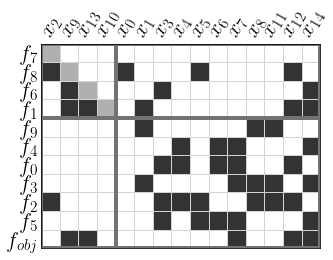

In [354]:
#synthetic_initial_blockmdf.png
save_img = True
vizargs_latex_largematrix = {'figsize':(5,5), 'rotation':60, 'hideticks':True, 'save':save_img, 'fontsize':22, 'patchwidth':4}
render_incidence(ordered_edges, ordered_tree, figname="synthetic_initial_blockidf.png", **vizargs_latex_largematrix);

In [37]:
ordered_tree = {i:1 for i in range(10)} | {'obj':1}, ordered_tree[1], ordered_tree[1]

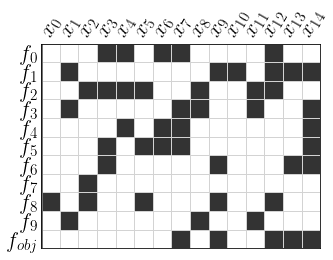

In [39]:
#synthetic_initial_blockmdf.png
save_img = True
vizargs_latex_largematrix = {'figsize':(5,5), 'rotation':60, 'hideticks':True, 'save':save_img, 'fontsize':22, 'patchwidth':4}
render_incidence(ordered_edges, ordered_tree, figname='synthetic_opt_sand.png', **vizargs_latex_largematrix);

## Full scale

In [135]:
from experimentutils import run_calculations
from itertools import product
import pandas as pd

In [136]:
def generate_problem(*args, df=None):
    data = []
    colnames = ["m", "ncoeff", "n", "sparsity", "seed", "poly_seed", "prob_type","mdf"]
    for m,ncoeff,sparsity,seed,poly_seed,prob_type,mdf in product(*args):
        n=m+int(ncoeff*m)
        if df is None or ((m, ncoeff, n, sparsity, seed, poly_seed, prob_type,mdf) not in df[colnames].itertuples(index=False)):
            data.append([m, ncoeff, n, sparsity, seed, poly_seed, prob_type,mdf])
    df2 = pd.DataFrame(data, columns=colnames)
    if df is not None:
        df2 = pd.concat([df, df2], ignore_index=True)
    return df2

In [137]:
df = generate_problem((10,),(0.5,),(1.,),range(10),range(10),(2,1),(True,False)) #df

In [149]:
df.to_csv('results_10x15_sparsity_1.csv')

In [139]:
fxs = {('maxscc', 'fobj', 'solveriter', 'optiter', 'time'): min_max_scc_calculations}

In [148]:
run_calculations(df, fxs, iter_cycles=400, filename=None, commonartifacts=generate_artifacts, 
                 argnames=["m", "n", "sparsity", "seed", "prob_type", "poly_seed", "mdf"])

IntProgress(value=0, max=400)

C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\solvers\nonlinear\newton.py:209: RuntimeWarning: invalid value encountered in double_scalars
  rec.rel = norm / norm0
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\solvers\solver.py:605: RuntimeWarning: invalid value encountered in double_scalars
  self._mpi_print(self._iter_count, norm, norm / norm0)
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\solvers\solver.py:612: RuntimeWarning: invalid value encountered in double_scalars
  while self._iter_count < maxiter and norm > atol and norm / norm0 > rtol and not stalled:


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_4', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_6', inds=[0]), ('inp.x_10', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_4', inds=[0]), ('inp.x_5', inds=[0]), ('inp.x_14', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_0', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_0', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_0', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_12', inds=[0]), ('inp.x_14', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_13', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


<lambdifygenerated-10247>:2: RuntimeWarning: overflow encountered in square
  return (x_0 - 1)**2 + (x_10 - 1)**2 + (x_13 - 1)**2 + (x_3 - 1)**2 + (x_9 - 1)**2
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_1', inds=[0]), ('inp.x_6', inds=[0]), ('inp.x_7', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


<lambdifygenerated-10991>:2: RuntimeWarning: overflow encountered in square
  return (x_0 - 1)**2 + (x_10 - 1)**2 + (x_13 - 1)**2 + (x_3 - 1)**2 + (x_9 - 1)**2


Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------


<lambdifygenerated-12355>:2: RuntimeWarning: overflow encountered in square
  return (x_1 - 1)**2 + (x_10 - 1)**2 + (x_13 - 1)**2 + (x_2 - 1)**2 + (x_5 - 1)**2
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1567: DerivativesWarning:Constraints or objectives [('f_obj.objobj', inds=[0])] cannot be impacted by the design variables of the problem.
C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_2', inds=[0]), ('inp.x_4', inds=[0]), ('inp.x_6', inds=[0]), ('inp.x_12', inds=[0]), ('inp.x_13', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Inequality constraints incompatible
-----------------------------------
Optimization FAILED.
Singular matrix E in LSQ subproblem
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Iteration limit reached
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------


C:\Users\johan\miniconda3\envs\minimdo\lib\site-packages\openmdao\core\total_jac.py:1596: DerivativesWarning:Design variables [('inp.x_7', inds=[0]), ('inp.x_8', inds=[0]), ('inp.x_14', inds=[0])] have no impact on the constraints or objective.


Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
Optimization FAILED.
Positive directional derivative for linesearch
-----------------------------------
